# Sentinel-2 기반 산불 피해 분석

### 코드 출처 및 수정 내역

이 분석 코드는 다음 공개 저장소의 예제를 기반으로 작성·업데이트되었습니다.

- 원본 코드: [UN-SPIDER / burn-severity-mapping-EO](https://github.com/UN-SPIDER/burn-severity-mapping-EO)

본 저장소에서는 위 코드를 참고하여 다음과 같은 부분을 수정·확장하였습니다.
- Sentinel-2 L2A jp2 파일을 직접 읽은 뒤  
  **반사율로 바꿔서 NBR / dNBR을 계산하도록 변경**  
  (이 부분이 실제 결과 값에 직접 영향을 줌)

- SCL(Scene Classification Layer)을 사용해  
  **구름, 그림자, 물, 결측 구역을 빼는 마스크 로직을 새로 도입**

- `osgeo.gdal/ogr/osr` 대신  
  **rasterio + geopandas만으로 재투영, 클리핑, GeoTIFF 저장을 처리**  
  (`reproject_shp`, `clip_raster`, `array2raster` 함수 작성)

- NBR / dNBR 계산 과정에서  
  **NaN, Inf 값이 생길 수 있는 경우를 고려해 안전하게 처리하도록 코드 수정**

### 환경 준비: pip 업그레이드 및 필요한 패키지 설치

이 코드 셀은 Jupyter Notebook이 사용하는 Python 환경을 최신 상태로 만들고,  
분석에 필요한 라이브러리들을 설치하는 과정입니다.

1. 첫 번째 명령은 현재 Notebook이 사용 중인 Python의 pip을 최신 버전으로 업데이트합니다.  
2. 두 번째 명령은 지리 정보 분석에 필요한 패키지들(rasterio, geopandas, shapely 등)을 설치합니다.

이 과정을 먼저 수행해야 이후 단계에서 위성영상과 지도 데이터를 문제 없이 다룰 수 있습니다.

In [1]:
import sys
!{sys.executable} -m pip install -U pip
!pip install -q -U rasterio geopandas shapely fiona numpy affine

### 필요한 라이브러리 불러오기

아래 코드는 위성영상과 지도 데이터를 다루기 위해 필요한 파이썬 라이브러리들을 불러옵니다.

- **os, glob**: 파일 경로를 찾거나 정리할 때 사용합니다.  
- **numpy**: 위성영상 데이터를 숫자 배열 형태로 계산할 때 사용합니다.  
- **rasterio**: 위성영상(jp2, tif)과 같은 래스터 데이터를 읽고 처리하는 데 사용합니다.  
- **geopandas**: 행정구역, 경계선(shapefile)과 같은 벡터 지도를 다룰 때 사용합니다.  
- **shapely**: 지도 경계나 도형을 계산할 때 사용합니다.  
- **affine**: 래스터 데이터의 좌표 변환(픽셀 → 실제 좌표)에 사용합니다.  
- **rasterio.mask**: 래스터를 특정 지역(shapefile 경계)에 맞게 잘라낼 때 사용합니다.

이 라이브러리들은 이후 단계에서 Sentinel-2 영상 불러오기, 산불 피해 지수 계산, 경계에 따라 영상 자르기 등의 작업을 수행하기 위해 필요합니다.

In [2]:
import os
import glob
import rasterio
import math
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

from rasterio.crs import CRS
from rasterio.mask import mask
from affine import Affine
from shapely.geometry import mapping

### Sentinel-2 영상 경로 설정

산불 전후의 Sentinel-2 위성영상이 저장된 폴더 위치를 지정하는 부분입니다.  
각 폴더는 `.SAFE` 구조로 되어 있으며, 그 안의 `IMG_DATA/R20m` 폴더에는  
20m 공간해상도의 밴드 이미지(jp2 파일)들이 들어 있습니다.

- **path_prefire** : 산불 발생 이전 날짜의 Sentinel-2 영상 경로  
- **path_postfire** : 산불 발생 이후 날짜의 Sentinel-2 영상 경로  

이 경로를 기반으로 이후 단계에서 특정 밴드(B8A, B12, SCL 등)를 불러오게 됩니다.

In [3]:
# 경로
path_prefire = "../S2A_MSIL2A_20230202T152641_N0510_R025_T19QCA_20240816T151554.SAFE/GRANULE/L2A_T19QCA_A039776_20230202T152642/IMG_DATA/R20m/"
path_postfire = "../S2B_MSIL2A_20230319T152639_N0510_R025_T19QCA_20240825T053107.SAFE/GRANULE/L2A_T19QCA_A031511_20230319T152642/IMG_DATA/R20m/"

In [4]:
def read_band_image(band, path, reflectance=True):
    """
    Sentinel-2 jp2 파일을 읽어서 배열과 공간정보를 반환.
    band: 파일명 중 '_{band}_{res}.jp2' 의 {band} 부분 (예: 'B8A', 'B12', 'SCL')
    path: 폴더 경로 (예: .../IMG_DATA/R20m/)
    reflectance: Bxx 계열 밴드를 반사율로 변환할지 여부
    """

    # 해상도 추출
    res = None
    if "R10m" in path:
        res = "10m"
    elif "R20m" in path:
        res = "20m"
    elif "R60m" in path:
        res = "60m"

    band_upper = band.upper()

    # 파일 패턴
    if res:
        pattern = os.path.join(path, f"*_{band_upper}_{res}.jp2")
    else:
        pattern = os.path.join(path, f"*_{band_upper}_*.jp2")

    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"No file found for band '{band}' in: {path}\nPattern: {pattern}")

    jp2_path = files[0]

    # Sentinel-2 L2A 기본 계수 (ESA 공식)
    # BOA reflectance = (DN + offset) / quantification_value
    quant_value = 10000.0        # BOA_QUANTIFICATION_VALUE
    offset_dn   = -1000.0        # BOA_ADD_OFFSET
    scale = 1.0 / quant_value    # 0.0001
    offset = offset_dn / quant_value   # -0.1

    # Bxx 밴드인지 판별 (SCL/AOT/WVP/TCI 제외)
    spectral_band = band_upper.startswith("B")

    with rasterio.open(jp2_path) as src:
        data = src.read(1).astype(np.float32)

        # 반사율 변환
        if reflectance and spectral_band:
            data = data * scale + offset      # DN*0.0001 - 0.1
            data = np.clip(data, 0, 1)        # 0~1 사이로 제한

        spatialRef = src.crs.to_wkt() if src.crs is not None else None
        geoTransform = src.transform.to_gdal()
        targetprj = src.crs if isinstance(src.crs, CRS) else src.crs

    return data, spatialRef, geoTransform, targetprj

### 1. 정규산불피해비율(NBR) 계산

정규산불피해비율(NBR, Normalized Burn Ratio)은  
산불 전후의 식생 변화와 피해 정도를 확인하기 위해 사용하는 지수입니다.

NBR은 Sentinel-2의 두 밴드를 활용해 계산합니다.

- **B8A** : 근적외선 밴드. 건강한 식생이 강하게 반사되는 영역  
- **B12** : 단중적외선 밴드. 탄화된 지역과 토양 노출이 잘 구분되는 영역  

NBR 계산 방식은 다음과 같습니다.

**NBR = (B8A - B12) / (B8A + B12)**

값의 해석:
- **높은 값** → 건강한 식생이 많은 지역  
- **낮은 값 또는 음수** → 산불 피해가 크거나 토양이 많이 노출된 지역  

이 지수를 기반으로 산불 전후 변화량(dNBR)을 계산하면 피해 등급 분류도 가능합니다.

In [5]:
# NBR 계산에 사용할 Sentinel-2 밴드 설정
band1 = 'B8A'
band2 = 'B12'
    
# 산불 전 영상에서 필요한 밴드 불러오기
(pre_fire_b8a, crs, geoTransform, targetprj) = read_band_image(band1, path_prefire)
(pre_fire_b12, crs, geoTransform, targetprj) = read_band_image(band2, path_prefire)

In [6]:
def nbr(band1, band2):
    """
    Normalized Burn Ratio(NBR)를 안전하게 계산하는 함수.

    Parameters
    ----------
    band1 : np.ndarray (예: B8A)
    band2 : np.ndarray (예: B12)

    Returns
    -------
    np.ndarray : NBR 값 (float32)
    """

    # Sentinel-2 밴드는 보통 uint16이므로 float로 변환
    band1 = band1.astype(float)
    band2 = band2.astype(float)

    # 0으로 나누기 등 오류를 방지하며 NBR 계산
    with np.errstate(divide='ignore', invalid='ignore'):
        nbr = (band1 - band2) / (band1 + band2)
        nbr = np.nan_to_num(nbr, nan=0.0, posinf=0.0, neginf=0.0)

    return nbr

In [7]:
# 산불 전 영상의 NBR 계산
pre_fire_nbr = nbr(pre_fire_b8a, pre_fire_b12)

In [8]:
# 산불 후 영상에서 필요한 밴드 불러오기
(post_fire_b8a, crs, geoTransform, targetprj) = read_band_image(band1, path_postfire)
(post_fire_b12, crs, geoTransform, targetprj) = read_band_image(band2, path_postfire)

In [9]:
# 산불 후 영상의 NBR 계산
post_fire_nbr = nbr(post_fire_b8a, post_fire_b12)

### 2. dNBR 계산

dNBR은 산불 전후의 변화를 정량적으로 평가하기 위한 지표로,  
산불 피해 정도를 파악하는 데 가장 널리 사용됩니다.

dNBR은 **산불 전 NBR 값에서 산불 후 NBR 값을 뺀 값**으로 계산됩니다.

**dNBR = NBR(전) - NBR(후)**

해석은 다음과 같습니다.

- **값이 클수록** → 산불로 인해 식생 손실이 크고 피해가 심함  
- **값이 작을수록** → 피해가 거의 없거나 미미함  
- **음수 값** → 산불 후 식생이 오히려 증가했거나 계절 요인 등으로 밝아진 지역

dNBR 값은 이후 피해 등급(미미, 경미, 중간, 심각 등)을 분류하는 데 활용됩니다.

In [10]:
def dnbr(nbr1, nbr2):
    """
    dNBR(delta NBR)을 안전하게 계산하는 함수.

    Parameters
    ----------
    nbr1 : np.ndarray
        산불 전 NBR 값
    nbr2 : np.ndarray
        산불 후 NBR 값

    Returns
    -------
    np.ndarray
        dNBR = NBR_pre - NBR_post
    """

    # 정수형이 들어올 경우를 대비해 float로 변환
    nbr1 = nbr1.astype(float)
    nbr2 = nbr2.astype(float)

    # 산불 전후 차이 계산
    dnbr = nbr1 - nbr2

    # NaN, inf 값이 있을 경우 안전하게 0으로 처리
    dnbr = np.nan_to_num(dnbr, nan=0.0, posinf=0.0, neginf=0.0)

    return dnbr

In [11]:
# dNBR 계산
dnbr = dnbr(pre_fire_nbr,post_fire_nbr)

### 3. Invalid Pixel Mask 적용

dNBR 계산 과정에서는 구름, 그림자, 결측값 등이 포함된 영역을  
정확한 분석에서 제외해야 합니다. 이를 위해 **Invalid Pixel Mask**를 적용합니다.

Invalid Pixel Mask는 Sentinel-2의 SCL(Scene Classification Layer) 또는  
사용자가 지정한 마스크를 기반으로 만들며, 유효하지 않은 픽셀을 0으로 처리합니다.

마스크 적용 방식은 다음과 같습니다.

- **유효한 픽셀** → 1  
- **무효한 픽셀(구름, 물, 그림자, 결측 등)** → 0  

이 마스크를 dNBR 또는 NBR 값과 곱하면  
유효한 지역만 남기고 나머지는 제거할 수 있습니다.

예:  
`dnbr_masked = dnbr * mask`

In [12]:
# 산불 전/후 SCL 레이어 불러오기
pre_scl,  _, _, _ = read_band_image("SCL", path_prefire)
post_scl, _, _, _ = read_band_image("SCL", path_postfire)

# 분석에서 제외할 SCL 클래스 정의 (No data, 결함 픽셀, 그림자, 구름 등)
bad_classes = np.array([0, 1, 3, 8, 9, 10])

# 각 시점별 마스크 생성 (True = 제외할 픽셀)
mask_pre  = np.isin(pre_scl,  bad_classes)
mask_post = np.isin(post_scl, bad_classes)

# 전/후 중 하나라도 제외 클래스에 포함되면 전체에서 제외
mask_bad = mask_pre | mask_post         # True = 제외
mask_good = ~mask_bad                   # True = 유효한 픽셀

# 유효한 픽셀만 남기고 나머지는 NaN 처리
dnbr_masked = np.where(mask_good, dnbr, np.nan)

In [13]:
def reproject_shp(infile, outfile, targetprj):
    """
    셰이프파일을 목표 좌표계로 재투영하는 함수.

    Parameters
    ----------
    infile : str
        입력 셰이프파일 경로
    outfile : str
        출력 셰이프파일 경로
    targetprj :
        목표 좌표계. 다음 형태 지원:
        - rasterio.crs.CRS 객체
        - WKT 문자열
        - 'EPSG:xxxx' 문자열
    """

    # 입력 셰이프파일 읽기
    gdf = gpd.read_file(infile)

    # 목표 CRS 준비
    if isinstance(targetprj, CRS):
        target_crs = targetprj.to_string()
    else:
        target_crs = targetprj

    # 입력 데이터에 CRS가 없으면 오류
    if gdf.crs is None:
        raise ValueError("입력 셰이프파일에 CRS가 없습니다. gdf.crs를 먼저 지정해야 합니다.")

    # 재투영
    gdf_out = gdf.to_crs(target_crs)

    # id 필드가 없으면 생성
    if 'id' not in gdf_out.columns:
        gdf_out['id'] = range(len(gdf_out))

    # 저장
    gdf_out.to_file(outfile, driver="ESRI Shapefile")

In [14]:
# 입력 셰이프파일 경로
infile_shp = "../WDPA_WDOECM_Oct2025_Public_478142_shp-polygons.shp"

# 재투영된 셰이프파일 저장 경로
outfile_shp = "projected.shp"

# Sentinel-2 래스터의 좌표계에 맞춰 셰이프파일 재투영
reproject_shp(infile_shp, outfile_shp, targetprj)

In [15]:
# 재투영된 셰이프파일 불러오기
fire_boundary = gpd.read_file(outfile_shp)

In [16]:
def array2raster(array, geoTransform, crs, filename,
                 nodata=None, dtype=np.float32):
    """
    numpy 배열을 GeoTIFF 파일로 저장하는 함수
    """

    # 배열 dtype 설정
    array = array.astype(dtype, copy=False)

    # geoTransform 정보를 Affine 형식으로 변환
    if isinstance(geoTransform, Affine):
        transform = geoTransform
    else:
        # GDAL 형식의 지오트랜스폼을 Affine으로 변환
        transform = Affine.from_gdal(*geoTransform)

    height, width = array.shape

    # GeoTIFF 저장
    with rasterio.open(
        filename,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=dtype,
        crs=crs,
        transform=transform,
        nodata=nodata
    ) as dst:
        dst.write(array, 1)

    return filename

In [17]:
# 출력할 dNBR GeoTIFF 파일 이름
filename = "dNBR.tif"

# dNBR 배열을 GeoTIFF로 저장
dnbr_tif = array2raster(
    dnbr_masked,
    geoTransform,
    crs,
    filename,
    nodata=0.0
)

In [18]:
def clip_raster(filename, shp):
    """
    셰이프파일 경계에 맞춰 래스터를 클리핑하는 함수.

    Parameters
    ----------
    filename : str
        입력 래스터 파일 경로
    shp : GeoDataFrame
        geopandas 로 읽은 셰이프파일

    Returns
    -------
    clipped : np.ndarray
        클리핑된 래스터 배열 (1 x height x width)
    clipped_meta : dict
        클리핑된 래스터의 메타데이터
    cr_ext : tuple
        클리핑된 영역의 외곽 범위(extent)
    gt : tuple
        GDAL 형식의 지오트랜스폼
    """

    # 입력 래스터 열기
    inraster = rasterio.open(filename)
    
    # 셰이프파일의 첫 번째 폴리곤을 GeoJSON 형태로 변환
    extent_geojson = mapping(shp['geometry'][0])

    # 셰이프파일 경계로 래스터 클리핑
    clipped, crop_affine = mask(
        inraster,
        shapes=[extent_geojson],
        nodata=np.nan,
        crop=True
    )

    # 메타데이터 복사 후 클리핑 정보로 업데이트
    clipped_meta = inraster.meta.copy()
    clipped_meta.update({
        "driver": "GTiff",
        "height": clipped.shape[1],
        "width": clipped.shape[2],
        "transform": crop_affine
    })

    # 클리핑된 영역의 좌표 범위 계산
    cr_ext = rasterio.transform.array_bounds(
        clipped_meta['height'],
        clipped_meta['width'],
        clipped_meta['transform']
    )

    # GDAL 형식 지오트랜스폼
    gt = crop_affine.to_gdal()
    
    return clipped, clipped_meta, cr_ext, gt

In [19]:
# 클리핑된 dNBR GeoTIFF 파일 이름
filename2 = "dNBR_clipped.tif"

# dNBR 래스터를 경계에 맞춰 클리핑
(clipped_dnbr, clipped_dnbr_meta, cr_extent, gt) = clip_raster(filename, fire_boundary)

# 클리핑된 dNBR을 새 GeoTIFF로 저장
clipped_tif = array2raster(
    clipped_dnbr[0],  # 첫 번째 밴드 (rows x cols)
    gt,               # clip_raster 에서 얻은 transform
    crs,              # Sentinel-2 CRS 사용
    filename2,        # 출력 파일 이름
    nodata=0.0
)

### 4. USGS 표준 등급 범위 설정

USGS(미국지질조사국)에서는 dNBR 값을 기반으로 산불 피해 정도를  
여러 단계로 구분하는 표준 분류 범위를 제공합니다.  
이는 산불 영향이 어느 정도인지 객관적으로 해석하는 데 사용됩니다.

USGS 기준 dNBR 분류 범위는 다음과 같습니다.

- **Unburned** : dNBR < 0.1  
- **Low Severity** : 0.1 ~ 0.27  
- **Moderate-low Severity** : 0.27 ~ 0.44  
- **Moderate-high Severity** : 0.44 ~ 0.66  
- **High Severity** : ≥ 0.66  

이 값들은 시각화(colormap), 통계 요약, 지도 제작 등에 그대로 활용할 수 있습니다.

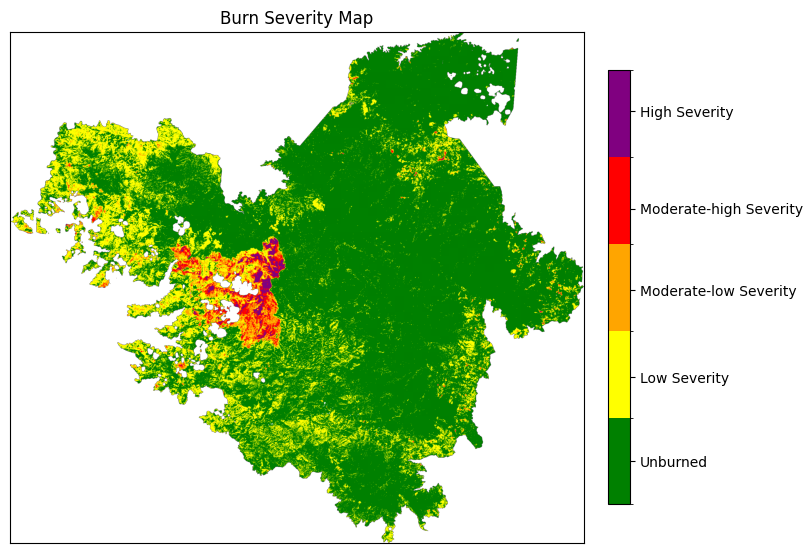

In [20]:
# 저장할 이미지 파일 경로
fname = "map.png"

# clipped_dnbr[0] : (rows, cols) 형태의 2D numpy array
data = clipped_dnbr[0]

# 색상 맵과 클래스 범위 설정
cmap = matplotlib.colors.ListedColormap(['green', 'yellow', 'orange', 'red', 'purple'])
cmap.set_over('purple')
cmap.set_under('white')

bounds = [-0.5, 0.1, 0.27, 0.440, 0.660, 1.3]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# 지도 생성
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})

# numpy array를 직접 시각화
cax = ax.imshow(data, cmap=cmap, norm=norm)

plt.title('Burn Severity Map')

# 색상 범례 설정
cbar = fig.colorbar(
    cax,
    ax=ax,
    fraction=0.035,
    pad=0.04,
    ticks=[-0.2, 0.18, 0.35, 0.53, 1]
)
cbar.ax.set_yticklabels([
    'Unburned',
    'Low Severity',
    'Moderate-low Severity',
    'Moderate-high Severity',
    'High Severity'
])

# 저장 후 출력
plt.savefig(fname, bbox_inches="tight", dpi=300)
plt.show()

### 5. 피해 등급별 면적 계산

dNBR 래스터와 USGS 등급 기준을 이용해,  
각 산불 피해 등급(예: Unburned, Low, Moderate, High)이 차지하는 면적을 계산할 수 있습니다.

기본 절차는 다음과 같습니다.

1. **dNBR 래스터를 등급별로 분류**  
   USGS 기준을 사용해 각 픽셀을 아래 등급으로 나눕니다.
   - Unburned  
   - Low Severity  
   - Moderate-low Severity  
   - Moderate-high Severity  
   - High Severity

2. **각 등급별 픽셀 수 계산**  
   분류된 래스터에서 동일한 등급 값을 가진 픽셀 개수를 셉니다.

3. **픽셀 크기를 이용해 면적으로 변환**  
   - Sentinel-2 dNBR 래스터가 20m 해상도라면,  
     한 픽셀 면적 = 20m × 20m = 400 m²  
   - 각 등급별 면적(m²)을 구한 뒤,  
     10,000으로 나누어 헥타르(ha) 단위로 변환합니다.

4. **등급별 면적 표 작성**  
   최종적으로 등급 이름과 면적(ha)을 표 형태로 정리해  
   보고서나 지도 범례 설명에 사용할 수 있습니다.

In [21]:
def reclassify(array):
    """
    dNBR 값을 USGS 기준에 따라 등급(1~5)으로 재분류하는 함수.

    Parameters
    ----------
    array : np.ndarray
        dNBR 값이 들어 있는 2D 배열

    Returns
    -------
    reclass : np.ndarray
        등급으로 재분류된 2D 배열
        (1=Unburned, 2=Low, 3=Moderate-low, 4=Moderate-high, 5=High)
    """

    # 출력 배열 초기화
    reclass = np.zeros((array.shape[0], array.shape[1]))

    # 픽셀 단위로 등급 분류
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):

            if math.isnan(array[i, j]):
                reclass[i, j] = np.nan

            elif array[i, j] < 0.1:
                reclass[i, j] = 1     # Unburned

            elif array[i, j] < 0.27:
                reclass[i, j] = 2     # Low severity

            elif array[i, j] < 0.44:
                reclass[i, j] = 3     # Moderate-low severity

            elif array[i, j] < 0.66:
                reclass[i, j] = 4     # Moderate-high severity

            else:
                reclass[i, j] = 5     # High severity

    return reclass

Low severity: 15117.88 ha
Moderate-low: 2065.16 ha
Moderate-high: 1257.56 ha
High severity: 560.56 ha

--- Burned Area Percentage ---
Low severity: 79.56%
Moderate-low: 10.87%
Moderate-high: 6.62%
High severity: 2.95%


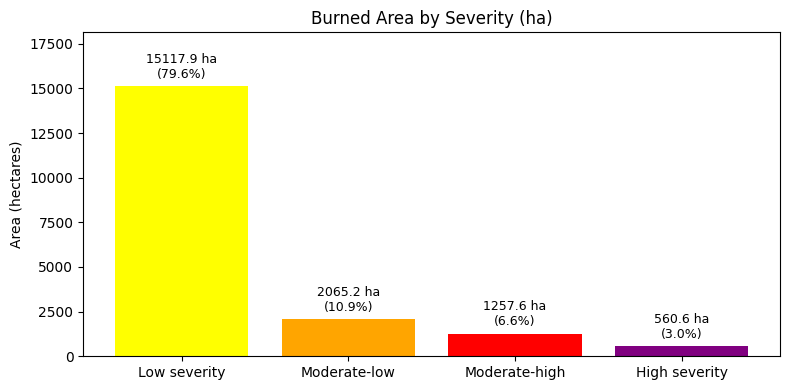

In [22]:
# 20m × 20m 해상도 기준으로 피해 면적 계산
reclass = reclassify(clipped_dnbr[0])

labels = [
    'Low severity',
    'Moderate-low',
    'Moderate-high',
    'High severity'
]

areas = []

# 산불 피해 지역
for i in range(2, 6):
    x = reclass[reclass == i]
    area_ha = x.size * 0.04   # 픽셀 → ha 변환 (400 m² = 0.04 ha)
    areas.append(area_ha)
    print(f"{labels[i-2]}: {area_ha:.2f} ha")

# 비율(%) 계산
total_burned = sum(areas)
percentages = [(a / total_burned) * 100 for a in areas]

print("\n--- Burned Area Percentage ---")
for label, pct in zip(labels, percentages):
    print(f"{label}: {pct:.2f}%")

# 그래프 그리기
plt.figure(figsize=(8, 4))
bars = plt.bar(labels, areas, color=['yellow', 'orange', 'red', 'purple'])

plt.title("Burned Area by Severity (ha)")
plt.ylabel("Area (hectares)")
plt.xticks()

# y축 상단에 여유 공간 확보
ymax = max(areas)
plt.ylim(0, ymax * 1.2)

# 막대 위에 면적 + % 라벨 표시
for bar, area, pct in zip(bars, areas, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + ymax * 0.02,         # 막대 꼭대기보다 약간 위에 라벨 배치
        f"{area:.1f} ha\n({pct:.1f}%)",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()

# PNG 저장
plt.savefig("burned_area_by_severity.png", dpi=300, bbox_inches='tight')
plt.show()